Import simulator and utilities

In [1]:
from src.base import FDTD2D
from src.detectors import PointDetector
from src.geometries import Rectangle,Circle
from src.sources import PointSource, LineSource

from src.viz import viz2D
from src.utilities import print_setup_info

In [2]:
# convert frequency
f = 1.5e14 #1/s
c = 299792458 #m/s
wavelength = c/f #m
print(wavelength)


1.9986163866666668e-06


### Testing initializations

In [3]:
tm_sim = FDTD2D(config_file = 'config.yaml')

Reading configuration from file...


### Set detectors

In [4]:
point_detector = PointDetector("point1", (98, 53))
tm_sim.add_detector(point_detector)

### Set sources

In [5]:
line_source = LineSource(x=tm_sim.line_x, y1=tm_sim.line_y1, y2=tm_sim.line_y2, function=tm_sim.function, frequency=tm_sim.frequency)
tm_sim.add_source(line_source)

### Set geometry

In [6]:
a = 1000e-9
r = 360e-9
w = 1200e-9
d = 1400e-9

In [7]:
print('w_nx',w/tm_sim.dx)
print('a_nx',a/tm_sim.dx)
print('r_nx',r/tm_sim.dx)
print('d_nx',d/tm_sim.dx)

w_nx 24.0
a_nx 20.0
r_nx 7.2
d_nx 28.0


In [8]:
centers_x = [46,66,86,114,134,154]

In [9]:
rectangle = Rectangle(x1=0, y1=37.5, x2=tm_sim.nx, y2=62.5,epsr=13, sigma=0)
tm_sim.add_geometry(rectangle)
tm_sim.update_grid()

c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
for center in centers_x:    
    tm_sim.add_geometry(Circle(center_x=center, center_y=50, radius=7.2, epsr=1, sigma=0))
    tm_sim.update_grid()

### Print simulation info

In [11]:
print_setup_info(tm_sim)

Simulation setup information:
nx: 200
ny: 100
time_steps: 5000
time: 0.0
dx: 5e-08
dy: 5e-08
dt: 1.6678204759907602e-16
use_pml: True
pml_thickness: 20
use_tfsf: False
polarization: TE
function: sinusoidal
frequency: 150000000000000.0
source_type: line_source
line x: 20
line y1: 40
line y2: 60
c: 299792458
epsilon_0: 8.85418782e-12
mu_0: 1.25663706e-06
geometries: [<src.geometries.rectangle.Rectangle object at 0x0000028B72A1D7F0>, <src.geometries.circle.Circle object at 0x0000028B72A1D6D0>, <src.geometries.circle.Circle object at 0x0000028B67429BB0>, <src.geometries.circle.Circle object at 0x0000028B6744BE20>, <src.geometries.circle.Circle object at 0x0000028B72A1D760>, <src.geometries.circle.Circle object at 0x0000028B72A1D430>, <src.geometries.circle.Circle object at 0x0000028B72A1DC40>]
sources: [<src.sources.line_source.LineSource object at 0x0000028B72A1DA00>]
detectors: [<src.detectors.point_detector.PointDetector object at 0x0000028B6744BB20>]


### Show material distribution

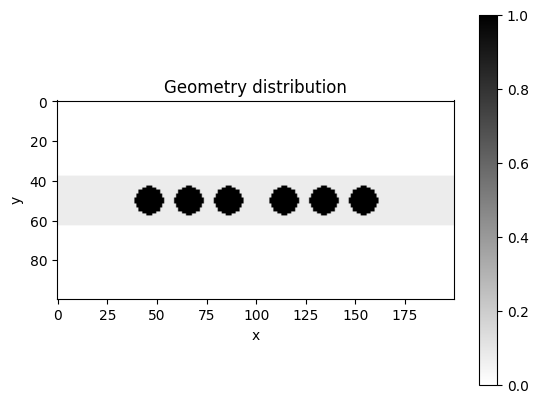

In [12]:
# Visualize permittivity distribution
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(np.transpose(tm_sim.gax), cmap='binary')
plt.title('Geometry distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(cmap='binary')
plt.show()

### Simulate

In [13]:
for i in range(1, tm_sim.time_steps):
    tm_sim.simulation_step(i)
    tm_sim.record_detectors(tm_sim.Ex)

### Visualize fields

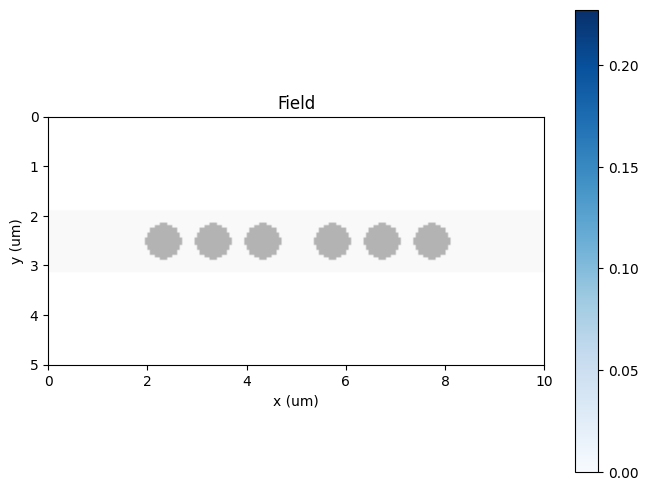

In [14]:
viz2D(tm_sim, tm_sim.Ex)

### Visualize detector

c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\mazzo\anaconda3\envs\fdtd\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


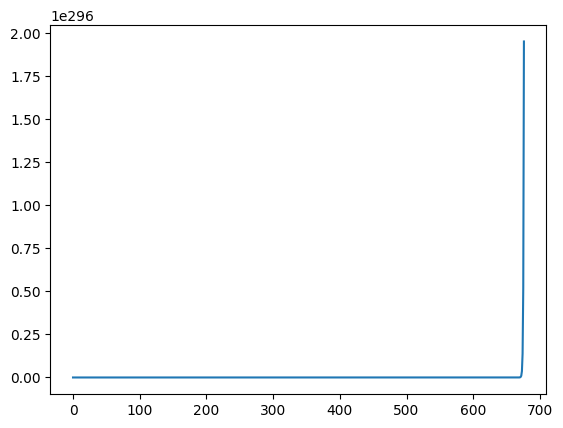

In [15]:
plt.plot(point_detector.recorded_values)

In [10]:
!pip install vtk

In [67]:
import numpy as np
import vtk
from vtk.util import numpy_support

tm_sim.nx, tm_sim.ny = tm_sim.Dz.shape

# Convert the numpy arrays to vtkImageData
energy_data = numpy_support.numpy_to_vtk(tm_sim.Dz.ravel(), deep=True, array_type=vtk.VTK_FLOAT)
geometry_data = numpy_support.numpy_to_vtk(tm_sim.gaz.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)

energy_image = vtk.vtkImageData()
energy_image.SetDimensions(tm_sim.nx, tm_sim.ny, 1)
energy_image.GetPointData().SetScalars(energy_data)

# geometry_image = vtk.vtkImageData()
# geometry_image.SetDimensions(tm_sim.nx, tm_sim.ny, 1)
# geometry_image.GetPointData().SetScalars(geometry_data)

# Create actors for energy and geometry data
energy_mapper = vtk.vtkDataSetMapper()
energy_mapper.SetInputData(energy_image)
energy_actor = vtk.vtkActor()
energy_actor.SetMapper(energy_mapper)

# geometry_mapper = vtk.vtkDataSetMapper()
# geometry_mapper.SetInputData(geometry_image)
# geometry_actor = vtk.vtkActor()
# geometry_actor.SetMapper(geometry_mapper)

# Set up the renderer and render window
renderer = vtk.vtkRenderer()
renderer.AddActor(energy_actor)
# renderer.AddActor(geometry_actor)
renderer.SetBackground(0.2, 0.2, 0.2)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(800, 800)

# Set up the interactor and start the visualization
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)
interactor.Initialize()
interactor.Start()